# Telecomunicaciones: Identificar operadores ineficaces de la compañia CallMeMaybe

Este análisis busca identificar a los operadores menos eficaces utilizando datos históricos de llamadas. Mediante un análisis exploratorio de datos, visualizaremos el comportamiento de las características importantes para entender las tendencias y los posibles problemas. Seguidamente, utilizaremos criterios definidos para clasificar a los operadores ineficaces, combinando factores como las llamadas perdidas y el tiempo de espera. Para finalizar, probaremos hipótesis para comprobar si existe una relación significativa entre estas variables y así determinar si los operadores ineficaces realizan menos llamadas salientes que el resto.

## Objetivos

### Objetivo general

Identificar a los operadores ineficaces del servicio de telefonía CallMeMaybe de acuerdo a la cantidad de llamadas perdidas, tiempo de espera y el número de llamadas salientes

### Objetivos específicos

1. Detectar a los operadores con alto porcentaje de llamadas perdidas.
2. Verificar los operadores que coinciden con el tiempo de espera prolongado.
3. Determinar cuantos operadores tienen bajo rendimiento en llamadas salientes.

## Lectura de datos

### Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns

### Cargar base de datos

In [2]:
#Creamos una ruta de archivo única para cargar el archivo dataset
try:
    path = 'C:/Users/erika/Desktop/data/proyecto_final/'
    data = pd.read_csv(path + 'telecom_dataset_us.csv')
except: 
    data = pd.read_csv('/datasets/telecom_dataset_us.csv')

In [3]:
#Creamos una ruta de archivo única para cargar el archivo clients
try:
    path = 'C:/Users/erika/Desktop/data/proyecto_final/'
    clients = pd.read_csv(path + 'telecom_clients_us.csv')
except: 
    clients = pd.read_csv('/datasets/telecom_clients_us.csv')

### Analizar tipo de datos y columnas

In [4]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [5]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [6]:
clients.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [7]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


### Valores nulos

La tabla data contiene valores nulos en las columnas de internal y operador_id, mientras que la tabla clients no contiene valores nulos.

## Preprocesamiento de datos

### Tratar valores nulos

Los valores nulos en operador id debemos eliminarlos ya que el propósito del proyecto es identificar los ineficaces, así que no hay sentido en estudiarlos si no hay manera de reconocer al operador. De igual manera eliminaremos las filas que no tienen información de las llamadas internas ya que este también es un parámetro que estaremos considerando en la eficacia.

In [8]:
data = data.dropna()

### Verificar duplicados

In [9]:
data.duplicated().sum()

4179

In [10]:
clients.duplicated().sum()

0

In [11]:
data = data.drop_duplicates()

### Convertir tipo de datos

In [12]:
#Convertiremos a fecha los datos correspondientes
data['date'] =  pd.to_datetime(data['date'], format="%Y-%m-%d")
clients['date_start'] =  pd.to_datetime(clients['date_start'], format="%Y-%m-%d")

In [13]:
# llamadas perdidas
data['is_missed_call'] = data['is_missed_call'].astype(int)

In [14]:
# dirección de la llamada
data['direction'] = data['direction'].replace({'in': 0, 'out': 1}) #entrante a 0 y saliente a 1
data['direction'] = data['direction'].astype(int)

In [15]:
# llamadas internas
data['internal'] = data['internal'].astype(int)

#### Datos adicionales
Agregaremos una columna con el tiempo de espera

In [16]:
data['waiting_time'] = data['total_call_duration'] - data['call_duration']
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
1,166377,2019-08-05 00:00:00+03:00,1,1,880022.0,1,3,0,5,5
2,166377,2019-08-05 00:00:00+03:00,1,1,880020.0,1,1,0,1,1
3,166377,2019-08-05 00:00:00+03:00,1,1,880020.0,0,1,10,18,8
4,166377,2019-08-05 00:00:00+03:00,1,0,880022.0,1,3,0,25,25
5,166377,2019-08-05 00:00:00+03:00,1,0,880020.0,0,2,3,29,26


## Análisis exploratorio de datos

### Visualizar estadística descriptiva

In [17]:
data.describe()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
count,41491.000000,41491.00000,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000
mean,167301.113543,0.69444,0.128462,916516.771155,0.340050,16.921381,1010.940011,1323.153238,312.213227
std,600.513986,0.46065,0.334607,21234.081589,0.473731,59.786187,4066.666485,4788.953155,1176.102940
min,166377.000000,0.00000,0.000000,879896.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,166782.000000,0.00000,0.000000,900790.000000,0.000000,1.000000,0.000000,67.000000,19.000000
50%,167175.000000,1.00000,0.000000,913938.000000,0.000000,4.000000,106.000000,289.000000,60.000000
75%,167827.000000,1.00000,0.000000,937708.000000,1.000000,14.000000,772.000000,1107.000000,219.000000
max,168606.000000,1.00000,1.000000,973286.000000,1.000000,4817.000000,144395.000000,166155.000000,46474.000000


### Visualizar distribuciones

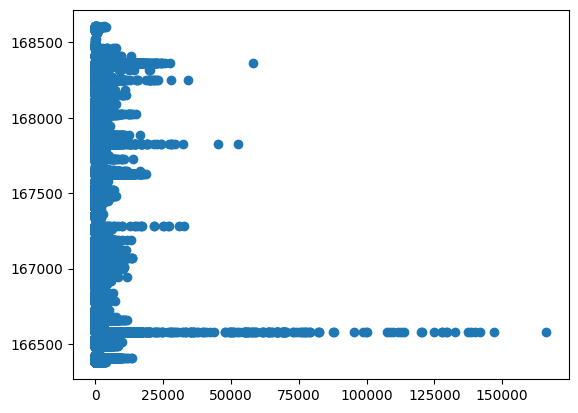

In [18]:
plt.scatter(data['total_call_duration'], data['user_id'])

In [19]:
#Filtraremos los datos con una duración de llamada superior a 100000
df = data[data['call_duration'] < 100000]

In [20]:
df.describe()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
count,41477.000000,41477.000000,41477.000000,41477.000000,41477.000000,41477.000000,41477.000000,41477.000000,41477.000000
mean,167301.356270,0.694337,0.128505,916527.113533,0.340164,16.610435,971.571039,1278.185332,306.614292
std,600.469949,0.460693,0.334655,21230.200237,0.473770,57.148706,3450.898942,4111.310099,1132.961607
min,166377.000000,0.000000,0.000000,879896.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,166782.000000,0.000000,0.000000,900792.000000,0.000000,1.000000,0.000000,67.000000,19.000000
50%,167175.000000,1.000000,0.000000,913938.000000,0.000000,4.000000,106.000000,289.000000,60.000000
75%,167827.000000,1.000000,0.000000,937708.000000,1.000000,14.000000,770.000000,1105.000000,219.000000
max,168606.000000,1.000000,1.000000,973286.000000,1.000000,4817.000000,98748.000000,113843.000000,46474.000000


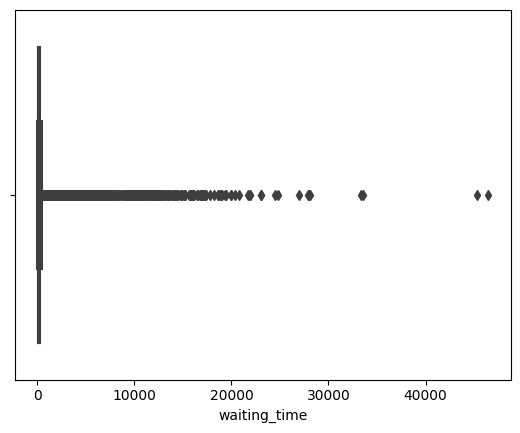

In [21]:
# Boxplot del tiempo de espera
sns.boxplot(x=df['waiting_time'])
plt.show()

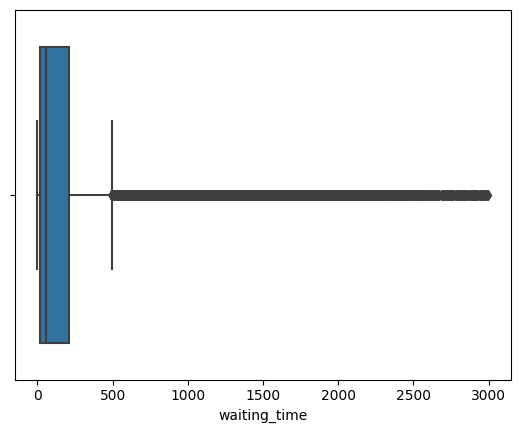

In [22]:
#Filtraremos tiempos de espera superiores a 3000
df_ = df[df['waiting_time'] < 3000]
sns.boxplot(x=df_['waiting_time'])
plt.show()

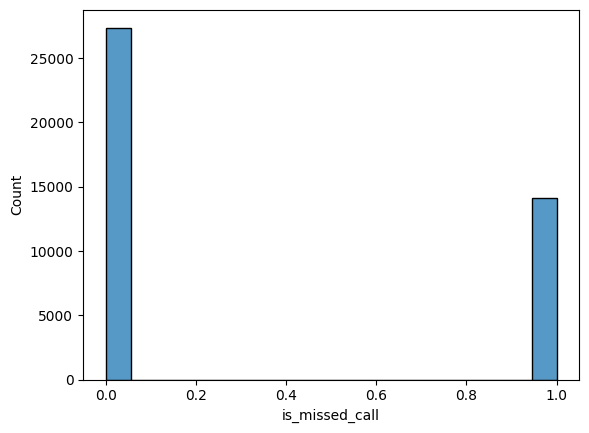

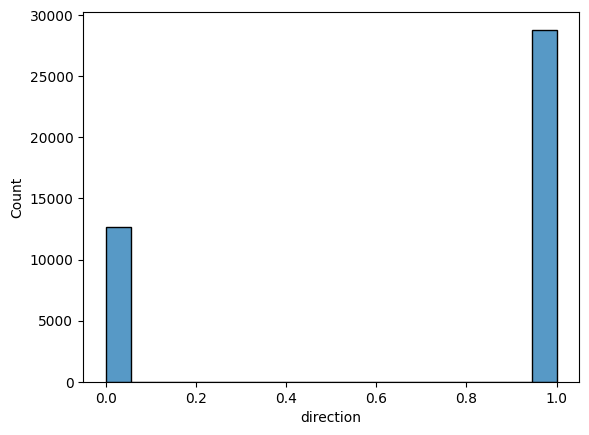

In [23]:
# Distribución de llamadas perdidas
sns.histplot(data['is_missed_call'])
plt.show()

# Distribución de llamadas salirntes
sns.histplot(data['direction'])
plt.show()

### Crear matriz de correlación

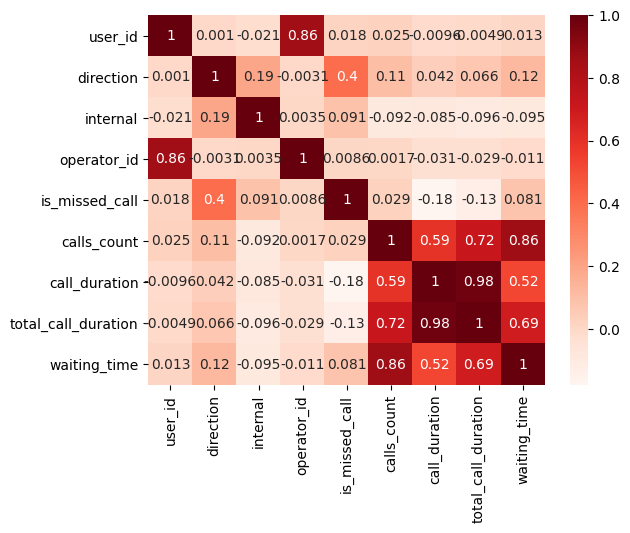

In [24]:
corr = data.corr()
sns.heatmap(corr, cmap='Reds', annot=True)
plt.show()

### Analizar porcentajes de las métricas

In [25]:
# Agrupar por operador y calcular el total de llamadas, número de llamadas perdidas, salientes y la suma del tiempo de espera
operators = df_.groupby('operator_id').agg(
    total_calls=('user_id', 'count'),
    missed_calls=('is_missed_call', 'sum'),
    out_calls=('direction', 'sum'),
    total_waiting_time=('waiting_time', 'sum'),
    mean_waiting=('waiting_time', 'mean')
).reset_index()

# Calcular los porcentajes
operators['por_missed_calls'] = (operators['missed_calls'] / operators['total_calls']) * 100
operators['por_out_calls'] = (operators['out_calls'] / operators['total_calls']) * 100

operators.head()

,operator_id,total_calls,missed_calls,out_calls,total_waiting_time,mean_waiting,por_missed_calls,por_out_calls
0,879896.0,117,47,96,12275,104.914530,40.170940,82.051282
1,879898.0,226,89,170,103890,459.690265,39.380531,75.221239
2,880020.0,20,6,13,280,14.000000,30.000000,65.000000
3,880022.0,70,29,62,3778,53.971429,41.428571,88.571429
4,880026.0,182,87,164,22200,121.978022,47.802198,90.109890


## Identificar operadores ineficaces

### Establecer eficacia

Para establecer la eficacia se deben considerar los siguientes criterios:

1. Cantidad de llamadas perdidas. Un porcentaje debajo del 25%
2. Tiempos de espera prolongados para atender las llamadas entrantes. Un promedio de 60
3. Número de llamadas salientes. Un porcentaje superior al 30%

De modo que la métrica combinada debe considerar numéricamente los 3 factores para ponderar la eficiencia. La métrica será:

                       Eficacia = llamadas perdidas + tiempo de espera - llamadas salientes
                       
Asignaremos los siguientes pesos:
llamadas perdidas (0.4), tiempo de espera (0.3), llamadas salientes (0.3)

                       
El umbral será que el resultado menor a 0.65 es un operador ineficaz

### Métrica combinada de eficiencia

#### Normalización de datos

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df = pd.DataFrame(operators)

df_normalized = df.copy()

#columnas que queremos normalizar
cols_to_normalize = ['por_missed_calls', 'mean_waiting', 'por_out_calls']

#Normalizamos
df_normalized[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])


#### Crear métrica

In [27]:
#Asignamos los pesos para cada criterio
w1, w2, w3 = 0.4, 0.3, 0.3

#calculamos la métrica de eficacia ponderada
df_normalized['eficacia'] = (
    w1 * (1 - df_normalized['por_missed_calls']) +  #menor porcentaje de llamadas perdidas es mejor
    w2 * (1 - df_normalized['mean_waiting']) +  #menor tiempo de espera es mejor
    w3 * df_normalized['por_out_calls']   #mayor porcentaje de llamadas salientes es mejor
)

#visualizamos por eficacia
df_normalized[['operator_id', 'eficacia']].sort_values(by='eficacia', ascending=False)


,operator_id,eficacia
1027,960666.0,0.999556
604,930692.0,0.999261
984,955086.0,0.999113
986,955094.0,0.998817
250,905470.0,0.998522
...,...,...
843,945278.0,0.521572
427,919162.0,0.511474
439,919206.0,0.510958
367,913886.0,0.498004


In [28]:
#Filtramos a los operadores ineficaces
ineficaces = df_normalized[df_normalized['eficacia']<0.7]

ineficaces

,operator_id,total_calls,missed_calls,out_calls,total_waiting_time,mean_waiting,por_missed_calls,por_out_calls,eficacia
7,881278.0,8,7,8,78,0.004805,0.875000,1.000000,0.648559
8,882476.0,3,0,0,95,0.015605,0.000000,0.000000,0.695318
9,882478.0,3,1,1,83,0.013634,0.333333,0.333333,0.662576
10,882680.0,43,3,0,1591,0.018234,0.069767,0.000000,0.666623
14,882690.0,63,23,41,36651,0.286693,0.365079,0.650794,0.663199
...,...,...,...,...,...,...,...,...,...
1080,970258.0,1,1,1,11,0.005421,1.000000,1.000000,0.598374
1083,971100.0,2,0,0,26,0.006406,0.000000,0.000000,0.698078
1084,971102.0,4,0,0,1352,0.166567,0.000000,0.000000,0.650030
1085,971354.0,2,0,0,84,0.020698,0.000000,0.000000,0.693791


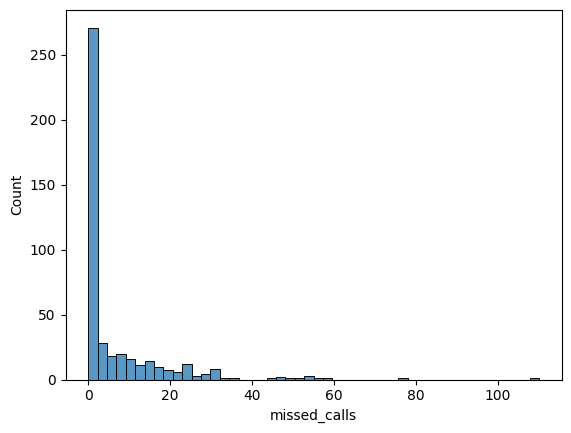

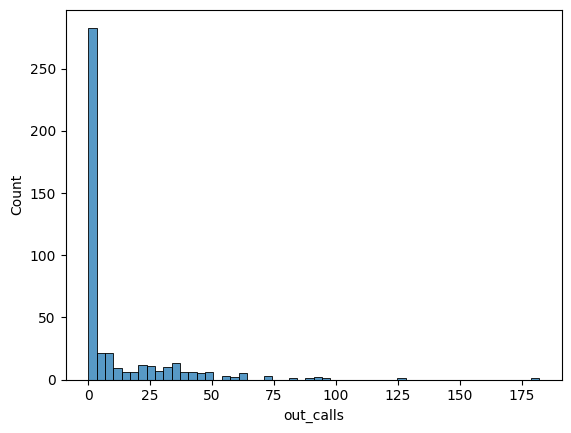

In [29]:
# Distribución de llamadas perdidas operadores ineficaces
sns.histplot(ineficaces['missed_calls'])
plt.show()

# Distribución de llamadas salirntes operadores ineficaces
sns.histplot(ineficaces['out_calls'])
plt.show()

## Prueba de hipótesis

In [30]:
df_.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
1,166377,2019-08-05 00:00:00+03:00,1,1,880022.0,1,3,0,5,5
2,166377,2019-08-05 00:00:00+03:00,1,1,880020.0,1,1,0,1,1
3,166377,2019-08-05 00:00:00+03:00,1,1,880020.0,0,1,10,18,8
4,166377,2019-08-05 00:00:00+03:00,1,0,880022.0,1,3,0,25,25
5,166377,2019-08-05 00:00:00+03:00,1,0,880020.0,0,2,3,29,26


###  Hipótesis 1: Los operadores con más llamadas perdidas tienen mayores tiempos de espera

In [31]:
from scipy.stats import pearsonr

#Calculamos correlación de Pearson
corr, p_value = pearsonr(df_['is_missed_call'], df_['waiting_time'])
print(f'Correlación: {corr}, p-valor: {p_value}')

#Declaramos la significancia
if p_value < 0.05:
    print("Estadísticamente significativa.")
else:
    print("No es estadísticamente significativa.")

Correlación: 0.11376726044604757, p-valor: 3.778015148050453e-118
Estadísticamente significativa.


Los resultados indican que la correlación no es fuerte ya que se encuentra muy cerca de 0. Sin embargo, el valor de p afirma que hay significancia estadística.

### Hipótesis 2: Los operadores más eficaces realizan mayores cantidades de llamadas salientes

In [32]:
from scipy.stats import ttest_ind

# Separar en grupos eficaces e ineficaces
eficaces_calls = df_normalized[df_normalized['eficacia'] <= 0.7]['out_calls']
ineficaces_calls = df_normalized[df_normalized['eficacia'] > 0.7]['out_calls']

# Prueba t
t_stat, p_value = ttest_ind(eficaces_calls, ineficaces_calls)
print(f'Estadístico t: {t_stat}, p-valor: {p_value}')
#Declaramos la significancia
if p_value < 0.05:
    print("Estadísticamente significativa.")
else:
    print("No es estadísticamente significativa.")

Estadístico t: -12.154171055577208, p-valor: 5.745329500775132e-32
Estadísticamente significativa.


## Conclusión

La base de datos contaba con algunos valores que debían corregirse como las filas con valores nulos y las filas duplicadas ya que afectarían el análisi, de igual modo fue requerido hacer algunos ajustes en los tipos de datos para poder procesar los cálculos correctamente. Seguido de eso se identificaron valores demasiado altos que afectaban las visualizaciones del tiempo de espera y la duración de llamada, se filtaron los valores máximos sin eliminarse todos ya que si había un número algo considerable de valores que salían de la caja en un boxplot. 

En el cálculo de la metrica para definir la eficacia, se requirió normalizar los datos previamente y calcular los porcentajes en los que se perdía una llamada, cuantas llamadas eran salientes y un promedio del tiempo de espera por operador. Se ponderaron los criterios estableciendose mayor peso a las llamadas perdidas. Finalmente se encontró que de los 1092 operadores, 442 son considerados ineficaces de acuerdo a la métrica descrita. Siendo el 40.48 % de los operadores. 

Por otro lado, se demostró que los operadores con más llamadas perdidas también tienen los mayores tiempos de espera, aunque la correlación de esta afirmación es algo debil. Así mismo podemos afirmar que los operadores más eficaces realizan mayores cantidades de llamadas salientes.

### Recomendaciones

Implementar sistemas de optimización del tiempo de espera, tales como capacitaciones, manuales y protocolos.

Redistribuir el volumen de llamadas a aquellos operadores con mayor cantidad de llamadas perdidas.

Establecer objetivos de llamadas salientes para mejorar las métricas.

Adoptar un sistema de incentivos de acuerdo a metas y evaluar periodicamente.

## Presentación

### PDF: 

https://drive.google.com/file/d/1UeucY9H_7-8K8GEXzkd4ufrioKc_8aVL/view?usp=sharing

### Dashboard:

https://public.tableau.com/views/Telecom_17283157754930/Dashboard1?:language=es-ES&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link